In [1]:
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os

In [16]:
def template_matching_with_mask(main_image_path, template_path, mask_threshold=200, threshold=0.9, scales=np.linspace(0.4, 0.5, 30)):
    """
    Perform template matching with mask on multiple object images.
    
    Args:
    main_image_path (str): Path to the main image.
    mask_threshold (int): Threshold for creating the mask.
    scales (numpy.ndarray): Array of scale factors for resizing.
    
    Returns:
    list: List of best match details for each object (position, size, correlation).
    """
    main_image = cv2.imread(main_image_path)
    if main_image is None:
        raise ValueError("Unable to read the main image")
    
    main_gray = cv2.cvtColor(main_image, cv2.COLOR_BGR2GRAY)
    best_matches = []

    object = cv2.imread(template_path)
    object_gray = cv2.cvtColor(object, cv2.COLOR_BGR2GRAY)
    _, object_mask = cv2.threshold(object_gray, mask_threshold, 255, cv2.THRESH_BINARY)
    
    # Show object mask
    plt.imshow(object_mask, cmap='gray')
    plt.axis('off')
    plt.title('Object Mask')
    plt.show()
    
    matches = find_best_match(main_gray, object_gray, object_mask, scales, threshold)

    for i, match in enumerate(matches):
        draw_result(main_image, match, i)

    task_index = main_image_path[-5]
    result_name = f'result_{task_index}.jpg'
    cv2.imwrite(result_name, main_image)
    return best_matches

def find_best_match(main_gray, object_gray, object_mask, scales, threshold=0.9):
    """
    Find the best match for an object in the main image across different scales.
    
    Args:
    main_gray (numpy.ndarray): Grayscale main image.
    object_gray (numpy.ndarray): Grayscale object image.
    object_mask (numpy.ndarray): Binary mask of the object.
    scales (numpy.ndarray): Array of scale factors for resizing.
    threshold (float): Threshold for considering a match.
    
    Returns:
    tuple: Best match details (position, size, correlation).
    """
    matches = []

    for scale in scales:
        resized_object = cv2.resize(object_gray, None, fx=scale, fy=scale)
        resized_mask = cv2.resize(object_mask, None, fx=scale, fy=scale)
        h, w = resized_object.shape

        result = cv2.matchTemplate(main_gray, resized_object, cv2.TM_CCOEFF_NORMED, mask=resized_mask)
        
        # Find all locations with high correlation
        locations = np.where(result >= threshold)
        for pt in zip(*locations[::-1]):  
            matches.append((pt, (h, w), result[pt[1], pt[0]]))
    
    # Remove duplicates
    matches = non_max_suppression(matches)
    
    return matches

def draw_result(main_image, match, i):
    """
    Draw the best match result on the main image.
    
    Args:
    main_image (numpy.ndarray): Main image to draw on.
    match (tuple): Match details (position, size, correlation score).
    i (int): Object index.
    """
    pt, (h, w), score = match
    cv2.rectangle(main_image, pt, (pt[0] + w, pt[1] + h), (0, 0, 0), 2)

def non_max_suppression(matches, overlap_thresh=0.01):
    """
    Perform non-maximum suppression on the matches.

    Args:
    matches (list): List of matches.
    overlap_thresh (float): Threshold for considering overlap.

    Returns:
    list: List of non-maximum suppressed matches.

    """
    if len(matches) == 0:
        return []
    
    pick = []
    x1 = np.array([m[0][0] for m in matches])
    y1 = np.array([m[0][1] for m in matches])
    x2 = np.array([m[0][0] + m[1][1] for m in matches])
    y2 = np.array([m[0][1] + m[1][0] for m in matches])
    scores = np.array([m[2] for m in matches])
    
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(scores)
    
    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
        
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        
        overlap = (w * h) / area[idxs[:last]]
        
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlap_thresh)[0])))
    
    return [matches[i] for i in pick]


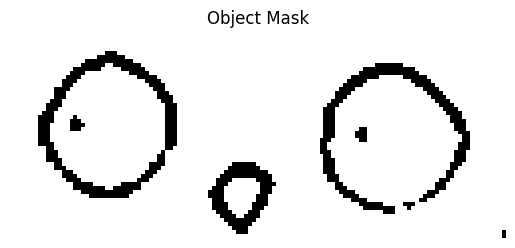

[]

In [17]:
template_matching_with_mask('cat.jpg', 'cat_eyes.png', mask_threshold=110, threshold=0.2)